# Imports

In [1]:
!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

Cloning into 'TensorFlow-Advanced-Segmentation-Models'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 677 (delta 45), reused 31 (delta 20), pack-reused 605
Receiving objects: 100% (677/677), 3.97 MiB | 29.67 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [2]:
print(os.getcwd())
%cd ..
import tensorflow_advanced_segmentation_models as tasm
%cd examples

/data111/bianhao/wyh/TensorFlow-Advanced-Segmentation-Models/examples
/data111/bianhao/wyh/TensorFlow-Advanced-Segmentation-Models


2022-11-25 15:48:40.283739: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/data111/bianhao/wyh/TensorFlow-Advanced-Segmentation-Models/examples


In [3]:
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from IPython.display import clear_output

## Download the Oxford-IIIT Pets dataset & Perform Augmentation

In [5]:
# tfds.load是一种方便的方法，它是构建和加载tf.data.Dataset的最简单方法。
# dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
# dataset, info = tfds.load("caltech_birds2011", with_info=True)
dataset, info = tfds.load('caltech_birds2010', download=False, data_dir='/data111/bianhao/wyh/TensorFlow-Advanced-Segmentation-Models/data', with_info=True)


In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## Define some global variables

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
N_CLASSES = 2
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb5"
WEIGHTS = "imagenet"

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

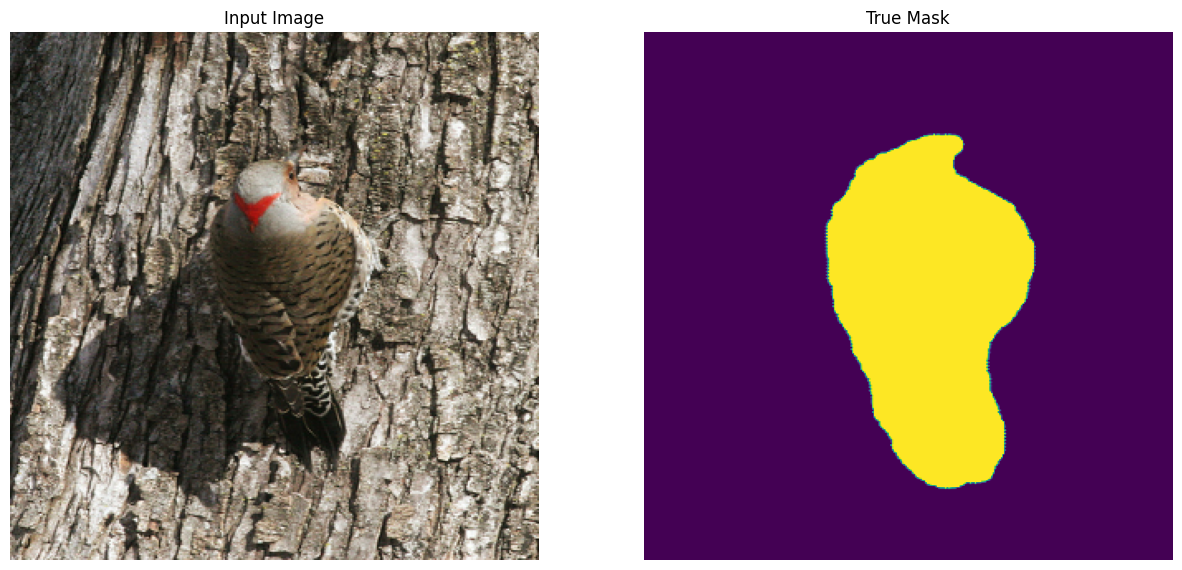

In [13]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image, sample_mask])

# Create the Model

In [14]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
model = tasm.UNet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

### Define the optimizer as well as losses, metrics and callbacks

In [15]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=7, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=19, mode="max", verbose=1, restore_best_weights=True)
]

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    # for yet unknown reasons 0s and 1s need to be inverted... something is not working properly in the training pipeline
    # that is why iou_score and val_iou_score are so low while fitting the model...
    pred_mask = pred_mask == 0
    pred_mask = tf.cast(pred_mask, tf.float32)
    return pred_mask[0]

2022-11-25 15:49:52.045994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-25 15:49:53.837093: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 3s 3s/step


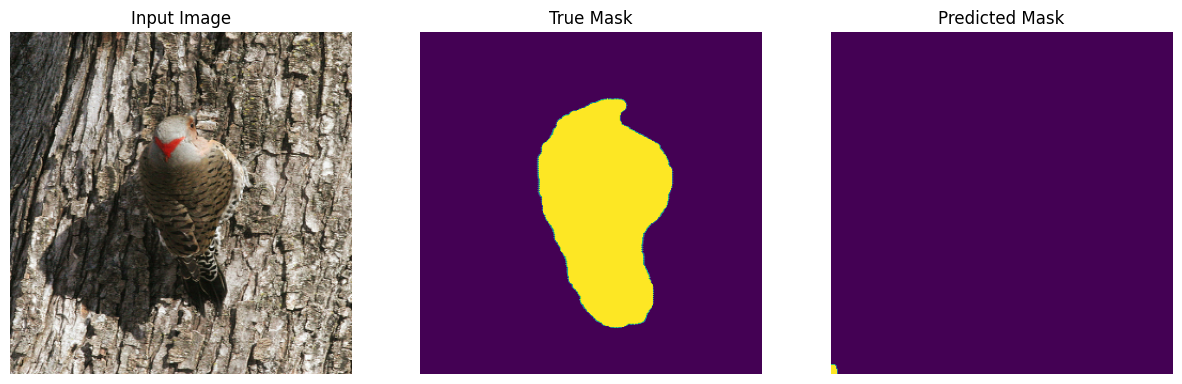

In [17]:
display([
         sample_image,
         sample_mask,
         create_mask(
             model.predict(sample_image[tf.newaxis, ...])
             )
         ])

# Training

## Training Procedure

##### 1) Train model with freezed backbone only on train data
##### 2) Train completly unfreezed model with train and validation data

### 1) Train model with freezed backbone only on train data

Set Backbone trainable to False.

In [18]:
for layer in model.layers:
    if "model" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

model: False
atrous_spatial_pyramid_pooling_v3: True
dropout: True
convolution_bn_activation_1: True
dropout_1: True
convolution_bn_activation_2: True
att_cf__module: True
concatenate: True
convolution_bn_activation_3: True
dropout_2: True
convolution_bn_activation_4: True
up_sampling2d: True


In [19]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=VALIDATION_STEPS,
    # validation_data=test_dataset,
    callbacks=callbacks
    )

Epoch 1/100
187/187 [==============================] - 64s 332ms/step - loss: 0.8481 - iou_score: 0.2348 - lr: 0.2000
Epoch 2/100
187/187 [==============================] - 60s 318ms/step - loss: 0.8099 - iou_score: 0.2606 - lr: 0.2000
Epoch 3/100
187/187 [==============================] - 61s 325ms/step - loss: 0.7899 - iou_score: 0.2664 - lr: 0.2000
Epoch 4/100
187/187 [==============================] - 61s 324ms/step - loss: 0.7749 - iou_score: 0.2701 - lr: 0.2000
Epoch 5/100
187/187 [==============================] - 66s 352ms/step - loss: 0.7604 - iou_score: 0.2736 - lr: 0.2000
Epoch 6/100
187/187 [==============================] - 61s 325ms/step - loss: 0.7482 - iou_score: 0.2768 - lr: 0.2000
Epoch 7/100
187/187 [==============================] - 58s 311ms/step - loss: 0.7402 - iou_score: 0.2774 - lr: 0.2000
Epoch 8/100
187/187 [==============================] - 56s 300ms/step - loss: 0.7330 - iou_score: 0.2778 - lr: 0.2000
Epoch 9/100
187/187 [==============================] - 5

2) Train completly unfreezed model with train and test data

<p>Make whole model trainable and additionally use validation set.</p>

In [20]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

model: True
atrous_spatial_pyramid_pooling_v3: True
dropout: True
convolution_bn_activation_1: True
dropout_1: True
convolution_bn_activation_2: True
att_cf__module: True
concatenate: True
convolution_bn_activation_3: True
dropout_2: True
convolution_bn_activation_4: True
up_sampling2d: True


In [21]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [22]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=callbacks
    )

Epoch 1/100
187/187 [==============================] - 80s 428ms/step - loss: 0.6511 - iou_score: 0.3270 - val_loss: 1.1320 - val_iou_score: 0.0804 - lr: 0.1000
Epoch 2/100
187/187 [==============================] - 79s 425ms/step - loss: 0.6261 - iou_score: 0.3577 - val_loss: 0.7087 - val_iou_score: 0.2475 - lr: 0.1000
Epoch 3/100
187/187 [==============================] - 79s 424ms/step - loss: 0.6170 - iou_score: 0.3690 - val_loss: 0.7380 - val_iou_score: 0.2119 - lr: 0.1000
Epoch 4/100
187/187 [==============================] - 79s 422ms/step - loss: 0.6118 - iou_score: 0.3753 - val_loss: 0.8010 - val_iou_score: 0.1323 - lr: 0.1000
Epoch 5/100
187/187 [==============================] - 71s 381ms/step - loss: 0.6078 - iou_score: 0.3805 - val_loss: 0.7415 - val_iou_score: 0.1799 - lr: 0.1000
Epoch 6/100
187/187 [==============================] - 70s 376ms/step - loss: 0.6042 - iou_score: 0.3851 - val_loss: 0.8904 - val_iou_score: 0.0879 - lr: 0.1000
Epoch 7/100
187/187 [=============

In [26]:
model

### Plot Training IoU Scores and Losses

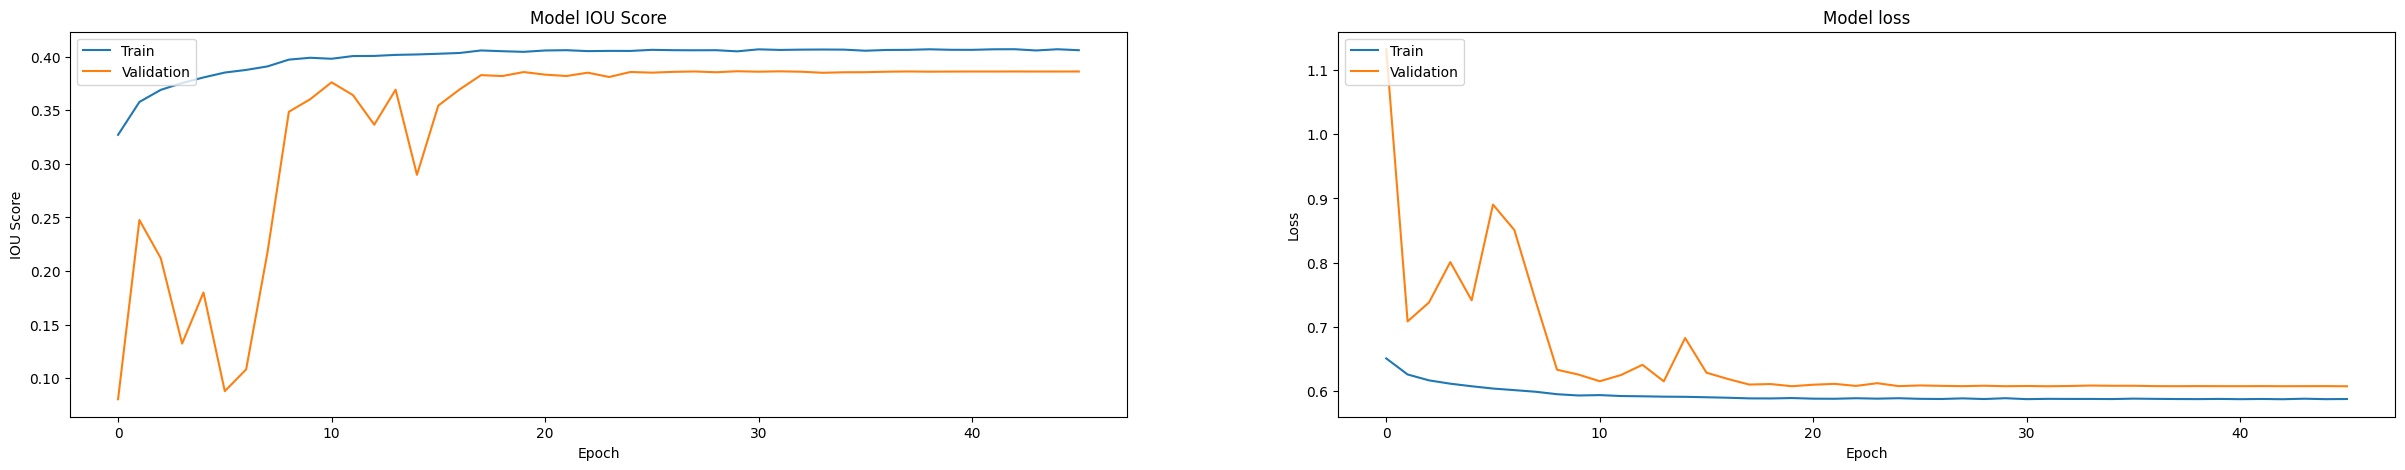

In [23]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Visual Examples on Test Data

1/1 [==============================] - 0s 145ms/step


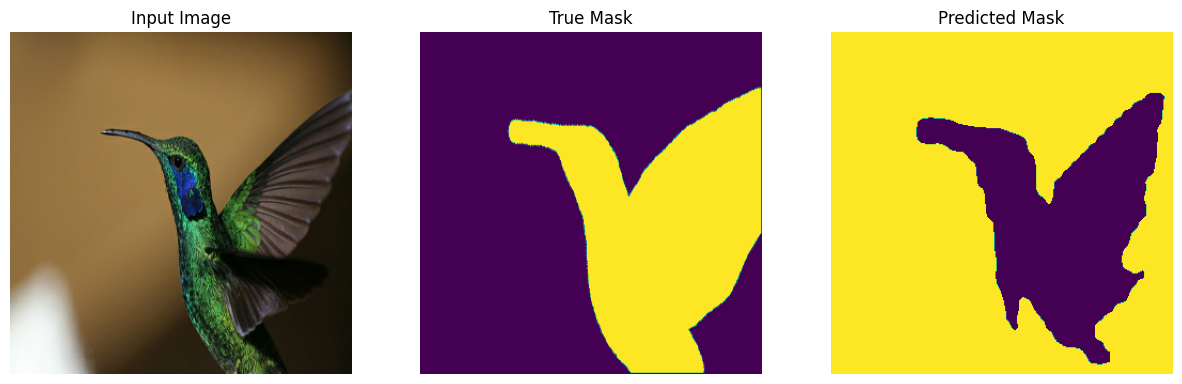

1/1 [==============================] - 0s 123ms/step


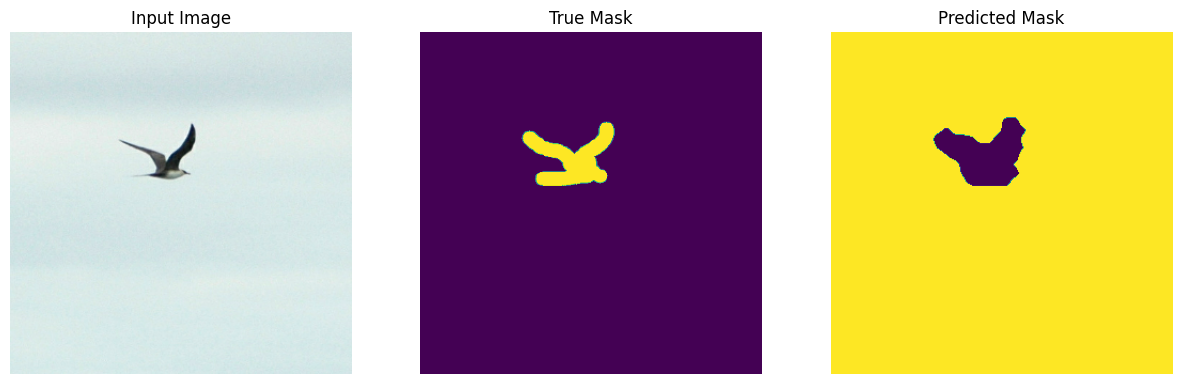

1/1 [==============================] - 0s 154ms/step


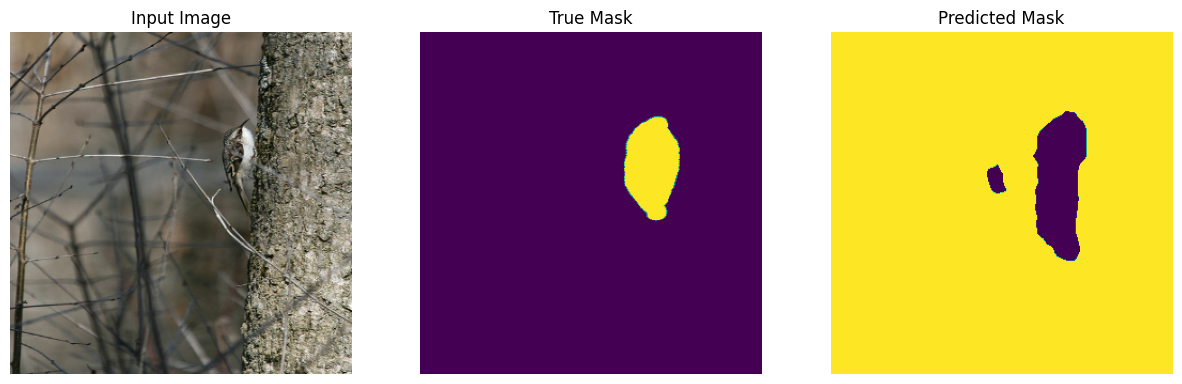

1/1 [==============================] - 0s 124ms/step


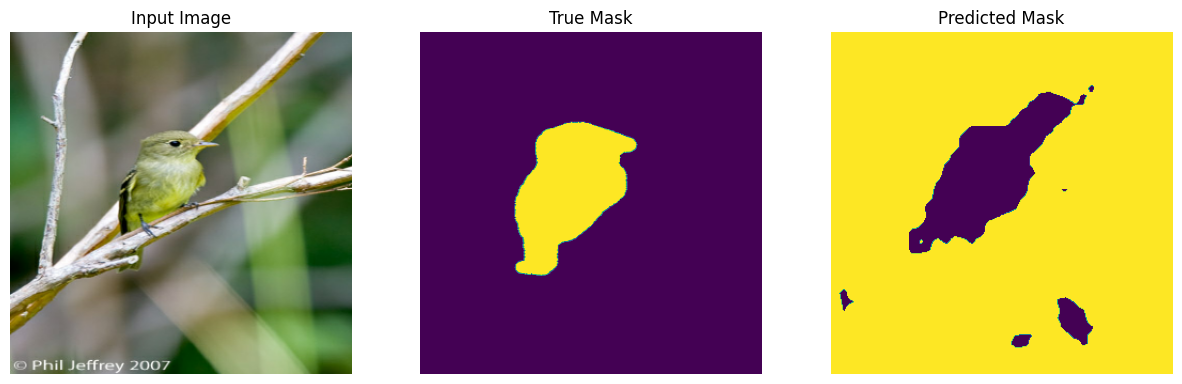

1/1 [==============================] - 0s 138ms/step


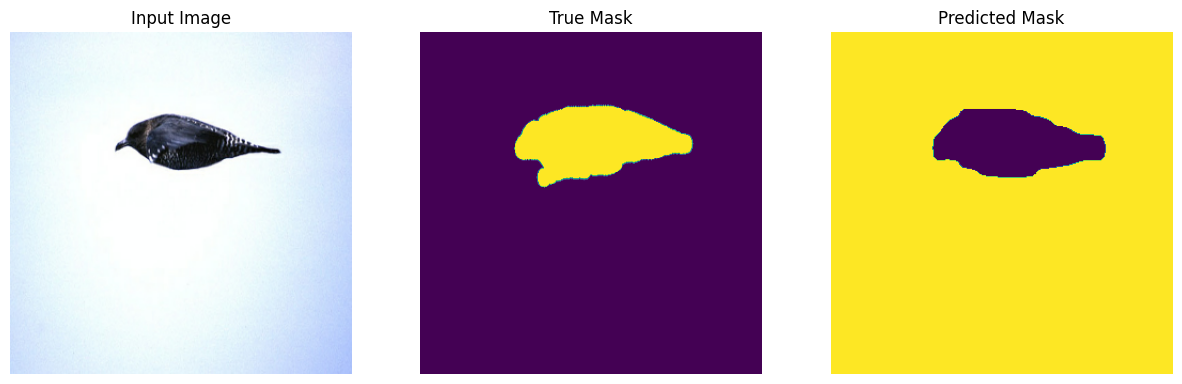

In [24]:
iou_scores = 0

for image, mask in test.take(5):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    display([
                sample_image,
                sample_mask,
                create_mask(output_model)
                ])
    # print(create_mask(output_model))

### Manually Calculating Test IoU-Score on 2500 images

In [25]:
iou_scores = 0

for image, mask in test.take(2500):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    iou_score = tasm.losses.iou_score(sample_mask, create_mask(output_model)).numpy()
    iou_scores += iou_score

print("Mean IoU-Score: " + str(iou_scores / 2500))

1/1 [==============================] - 0s 123ms/step
Mean IoU-Score: 0.026720588952144214
